<a href="https://colab.research.google.com/github/justin-bardwell/Kaggle-RSNA-MICCAI/blob/main/Setup_and_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **RSNA-MICCAI Brain Tumor Radiogenomic Classification**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/justin-bardwell/Kaggle-RSNA-MICCAI/blob/main/TEST-brain-tumor-eda-for-starter-english-version.ipynb)

https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification


https://drive.google.com/drive/folders/1aMKv-GfepkHkpRnZRnxxMJhGezVGClnV?usp=sharing


This is an interesting Kaggle competition that recently opened which relates to Brain Tumour Radiogenomic Classification. The purpose of this is to provide techniques to detect the presence of a specific genetic sequence in brain tumours which has been shown to be a favourable prognostic factor and a strong predictor of responsiveness to chemotherapy. Currently, the genetic analysis of cancer requires surgery to extract a tissue sample. 

In Kaggle, we are provided with data which includes four types of whole brain MRI scans (FLAIR, T1w, T1Gd, T2w) for each subject as well as the MGMT promoter methylation status assoc"iated with each subject. Methylated cases are marked as '1' and unmethylated as '0' in the data. The task is to predict a probability for the target MGMT value of each subject based on the MRI scans we are provided. Submissions are evaluated on the area under the ROC curve between the predicted probability and the observed target.


### Setup Github access through Google Colab
- Navigate to http://colab.research.google.com/github.
- Click the "Include Private Repos" checkbox.
- In the popup window, sign-in to your Github account and authorize Colab to read the private files.
- Your private repositories and notebooks will now be available via the github navigation pane.

### Access Google Drive files

All data files can be found in the following Google Drive. 

https://drive.google.com/drive/folders/1aMKv-GfepkHkpRnZRnxxMJhGezVGClnV?usp=sharing

The data contained in this drive comes from the following Kaggle discussion: https://www.kaggle.com/c/rsna-miccai-brain-tumor-radiogenomic-classification/discussion/253000 

By using PNG files instead of the originally provided DICOM files, we greatly save on storage space and resources for our initial exploration and learning of the data.

You should create a copy of the data and store it in a folder called 'Kaggle' in your own Google Drive.

Run the below script to mount your Google Drive



In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

# Click the link below to authenticate user Google account
# Copy and Paste the authentication code into the input cell

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# Change your directory to where the data is stored
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


In [3]:
import numpy as np
import pandas as pd
import os

## 1. What are the values we want to predict?

Have a look into the training labels file provided.

In [4]:
train_labels = pd.read_csv("train_labels.csv")
train_labels

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


* BraTS21ID is the patient's Id,

* Methylated cases are marked as '1' and unmethylated as '0' in the data. The task is to predict a probability for the target MGMT value of each subject based on the MRI scans we are provided.

Have a look at the sample submission file provided by Kaggle:

In [5]:
sample = pd.read_csv("sample_submission.csv")
sample

,BraTS21ID,MGMT_value
0,1,0.5
1,13,0.5
2,15,0.5
3,27,0.5
4,37,0.5
...,...,...
82,826,0.5
83,829,0.5
84,833,0.5
85,997,0.5


As seen above, the MGMT_value we want to predict should be a value between 0 and 1 where this value represents the probability of a subject being a methylated case. Our submissions will be evaluated on the area under the ROC curve between the predicted probability and the observed target.

# 2. What do our training instances look like?

## 2.1 Train.csv file structure

In [6]:
train_labels

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1
...,...,...
580,1005,1
581,1007,1
582,1008,1
583,1009,0


The training data contains four types of whole brain MRI scans (FLAIR, T1w, T1wCE, and T2w) as shown below.

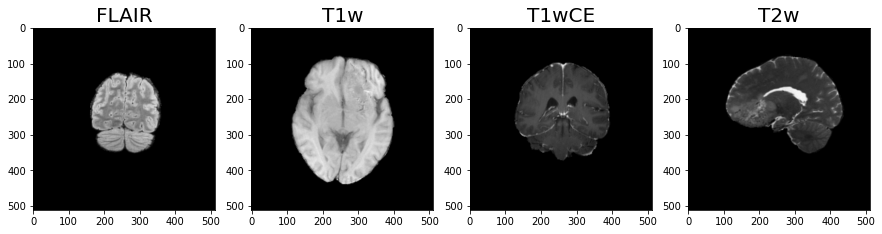

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img1 = mpimg.imread('train/00000/FLAIR/Image-100.png')
img2 = mpimg.imread('train/00000/T1w/Image-16.png')
img3 = mpimg.imread('train/00000/T1wCE/Image-52.png')
img4 = mpimg.imread('train/00000/T2w/Image-168.png')

scans = ['FLAIR', 'T1w', 'T1wCE', 'T2w']
imgs = [img1, img2, img3, img4]

plt.figure(figsize=(15, 5))
plt.gray()

for i in range(len(scans)):
    plt.subplot(1, 4, i+1)
    plt.imshow(imgs[i])
    plt.title(scans[i], fontsize=20)

plt.show()

The above images show one image from the FLAIR, T1w, T1wCE and T2w scans for subject 0.

For each subject, there are many scans of each type.

## 2.2 Inspect how many scans there are for each subject


Create a new dataframe which contains our training data and the index of the folders which the images are contained.

https://paperswithcode.com/